<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 5: Maximum Likelihood Learning

### Applied Machine Learning

__Volodymyr Kuleshov__<br>Cornell Tech

# Why Does Supervised Learning Work?

Prevously, we saw one way of explaining why supervised learning works.



# Part 1: Probabilistic Modeling

In this lecture, we are going to look at why supervised learning works from a new, probabilistic perspective.

First, we are going to start by defining the probabilistic approach to machine learning and set up some notation.

# Review: Machine Learning Models

A machine learning model is a function
$$ f : \mathcal{X} \to \mathcal{Y} $$
that maps inputs $x \in \mathcal{X}$ to targets $y \in \mathcal{Y}$.

Often, models have *parameters* $\theta \in \Theta$ living in a set $\Theta$. We will then write the model as
$$ f_\theta : \mathcal{X} \to \mathcal{Y} $$
to denote that it's parametrized by $\theta$.

# Review: Data Distribution

We will assume that the dataset is governed by a probability distribution $\mathbb{P}$, which we will call the *data distribution*. We will denote this as
$$ x, y \sim \mathbb{P}. $$

The training set $\mathcal{D} = \{(x^{(i)}, y^{(i)}) \mid i = 1,2,...,n\}$ consists of *independent and identicaly distributed* (IID) samples from $\mathbb{P}$.

# Probabilistic Models

A probabilistic model is a probability distribution
$$P(x,y) : \mathcal{X} \times \mathcal{Y} \to [0,1].$$
This model can approximate the data distribution $\mathbb{P}(x,y)$.

Probabilistic models also have *parameters* $\theta \in \Theta$, which we denote as
$$P_\theta(x,y) : \mathcal{X} \times \mathcal{Y} \to [0,1].$$

If we know $P_\theta(x,y)$, we can use the conditional $P_\theta(y|x)$ for prediction.

# Probabilistic Models: Example

Consider a simple version of our example with predicting diabetes from BMI.
* For the target $\mathcal{Y} = \{0, 1\}$, we discretize the diabetes risk score into low risk ($y=0$) and high risk ($y=1$).
* For the input $\mathcal{X} = \{0, 1, 2\}$, we also discretize the BMI into low ($x=0$), medium ($x=1$), and high ($x=2$).

Then the following is a simple probabilistic model.

<!-- | BMI $x$     | Risk $y$    | P(x,y)      |
| ----------- | ----------- | ----------- |
| low         | low         | 0.2         |
| medium      | low         | 0.1         |
| high        | low         | 0.2         |
| low         | high        | 0.05        |
| medium      | high        | 0.1         |
| high        | high        | 0.35        | -->

In [18]:
import pandas as pd

df_model = pd.DataFrame.from_records([
    ['low', 'low', 0.20], ['medium', 'low', 0.1], ['high', 'low', 0.2],  
    ['low', 'high', 0.05], ['medium', 'high', 0.1], ['high', 'high', 0.35],      
], columns=['BMI $x$', 'Risk $y$', 'P'])
df_model

,BMI $x$,Risk $y$,P
0,low,low,0.20
1,medium,low,0.10
2,high,low,0.20
3,low,high,0.05
4,medium,high,0.10
5,high,high,0.35


Under this model, we can compute $P(y|x) = P(x, y)/P(x)$ as follows.

In [26]:
df_px = df_model.groupby('BMI $x$').sum().rename(columns={'P' : 'Px'})
df_conditional_model = df_model.merge(df_px, on='BMI $x$', right_index=True)
df_conditional_model['$P(y|x)$'] = df_conditional_model['P'] / df_conditional_model['Px'] 
df_conditional_model.iloc[:,[0,1,4]]

,BMI $x$,Risk $y$,$P(y|x)$
0,low,low,0.800000
3,low,high,0.200000
1,medium,low,0.500000
4,medium,high,0.500000
2,high,low,0.363636
5,high,high,0.636364


# Why Use Probabilistic Models?

The probabilistic approach to machine learning is powerful.

* We can fit models that capture predictive *uncertainty*.

* We can construct models in a more principled way by explicitly modeling the data distribution.

* It offers a new perspective on why supervised learning works.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 2: Monte Carlo Estimation

Next, we are going to define Monte Carlo sampling, a mathematical tool that will be important in this lecture and later in the course.

# Notation: Random Variable

Suppose that we have a variable $x \in \mathcal{X}$ that is governed by a distribution $\mathbb{P}$:
$$ x \sim \mathbb{P}(x). $$
This $x$ can be a sample from a data distribution, or any other random variable.

# Notation: Expected Value

Recall that the expected value of a function $g : \mathcal{X} \to \mathbb{R}$ when the input $x$ to $g$ is sampled from $\mathbb{P}$ is given by
$$ E_{x \sim P}[g(x)] = \sum_{x} g(x) P(x), $$
where we assumed for simplicity that $x$ is discrete.

In practice computing expected values is not always easy:
* $x$ can take on a very large number of values and summing over all of them is not possible.
* When $x$ is continuous, the expected value can be an integral with no closed form solution.

In practice, we often use *approximate* methods to compute expected values.

# Monte Carlo Estimation

Monte Carlo estimation is a way to approximately compute exepected values
$$ E_{x \sim P}[g(x)] = \sum_{x} g(x) P(x).$$

1. We first generate $T$ IID samples $x_1,\ldots,x_T$ from $P$.

2. Then we estimate the expected value as:
  $$ \hat{g}(x_1,\cdots,x_T) \triangleq \frac{1}{T} \sum_{t=1}^{T} g(x_t) $$
We call $\hat g$ the Monte Carlo estimate of the expected value.

# Monte Carlo Estimation: Example

Let's say that we throw five dice. What is the expected number of twos?

* Let $x = (x_1, x_2, \ldots, x_5)$ be a dice roll where $x_j \in \{1,2,\ldots,6\}$ is the outcome of the $j$-th die.

* Let $g(x)$ denote the number of twos in the roll of dice $x$.

The expected value $E_{x \sim P}[g(x)] = \sum_{x} g(x) P(x)$ is the expected number of twos. We can calculate it as follows

In [57]:
import numpy as np

# sample 10,000 rolls of five dice
dice_rolls = np.random.randint(0, 6, size=(5,10000))

# count the number of twos in each throw
TWO_VAL = 1 # twos are denoted by 1 because of zero-based indexing
num_twos = (dice_rolls==TWO_VAL).sum(axis=0).mean()

print('MC Estimate: %.4f' % num_twos)

MC Estimate: 0.8358


This makes sense, since the correct answer is $5/6 \approx 0.83$.

# Properties of Monte Carlo Estimation

The Monte Carlo estimate $\hat g$ has the following properties:

* It is an unbiased estimate of the true expectation:
$$ E_P[\hat{g}]=E_P[g(x)] $$

* It converges to the true expectation as we average additional samples.
$$ \hat{g} = \frac{1}{T} \sum_{t=1}^{T} g(x_t) \rightarrow E_P[g(x)] \mbox{ for } T \rightarrow \infty $$

* It's variance decreases to zero as we collect more samples:
$$ \text{var}_P[\hat{g}]=\text{var}_P \left [ \frac{1}{T} \sum_{t=1}^{T} g(x_t) \right ] = \frac{\text{var}_P[g(x)]}{T} $$
Thus, variance of the estimator can be reduced by increasing the number of samples. 

# Monte Carlo: Summary

* A lot of problems in ML require computing intractable expected values.
* Monte Carlo estimation is a simple approximate method that computes expected values approximately.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 3: Maximum Likelihood

Maximum likelihood learning is a general way of training machine learning models. Many algorithms we've seen so far implicitly use this principle.

# Review: Data Distribution

We will assume that the dataset is governed by a probability distribution $\mathbb{P}$, which we will call the *data distribution*. We will denote this as
$$ x, y \sim P_\text{data}. $$

The training set $\mathcal{D} = \{(x^{(i)}, y^{(i)}) \mid i = 1,2,...,n\}$ consists of *independent and identicaly distributed* (IID) samples from $P_\text{data}$.

# Review: Probabilistic Models

A probabilistic model is a probability distribution
$$P_\theta(x,y) : \mathcal{X} \times \mathcal{Y} \to [0,1].$$
This model can approximate the data distribution $P_\text{data}(x,y)$.

Probabilistic models may also have *parameters* $\theta \in \Theta$, which we denote as
$$P_\theta(x,y) : \mathcal{X} \times \mathcal{Y} \to [0,1].$$

If we know $P(x,y)$, we can use the conditional $P(y|x)$ for prediction.


# Learning Probabilistic Models

We now have a probabilistic model and a data distribution. Thus, it is natural to try to learn learn a good probability distribution $P_\theta(x,y)$ that approximates $P_\text{data}(x,y)$.

What are the characteristics of a good model $P_\theta(x, y)$?
* Predictive accuracy: correctly predicting $y$ from $x$.
    * Does this patient have diabetes or not?

* Understanding the relationship between $x, y$?
    * What physiological features of the patient influence their diabetes risk?

* Density estimation: approximating $P_\text{data}(x,y)$ so that we can later answer any query.

# Kullback-Leibler Divergence

In order to approximate $P_\text{data}$ with $P_\theta$, we need a measure of distance between distributions.

A standard measure of similarity between distributions is the *Kullback-Leibler (KL) divergence* between two distributions $p$ and $q$, defined as
$$
D(p \| q) = \sum_{{\bf x}} p({\bf x}) \log \frac{p({\bf x})}{q({\bf x})}.
$$

#### Observations:
* $D(p \, \| \, q) \geq 0$ for all $p, q$, with equality if and only if $p= q$. Proof:
\begin{align*}
	D(p \| q) = \mathbb{E}_{x\sim p}{-\log \frac{q({\bf x})}{p({\bf x})}} & \geq -\log \left( \mathbb{E}_{x\sim p} {\frac{q({\bf x})}{p({\bf x})}} \right) \\ = &
	-\log \left( \sum_{{\bf x}} p({\bf x}) \frac{q({\bf x})}{p({\bf x})} \right)
	=
	0
\end{align*}

* The KL-divergence is *asymmetric*, i.e., $D(p \| q) \neq D(q \| p)$

* It has roots in information theory.

# Learning Models Using KL Divergence

We may now learn a probabilistic model $P_\theta(x,y)$ that approximates $P_\text{data}(x,y)$ via the KL divergence:
\begin{align*}
D(P_{\textrm{data}} \mid \mid {P_\theta}) & = \mathbb{E}_{x,y \sim P_{\textrm{data}}}{\log\left(
\frac{P_{\textrm{data}}(x, y)}{P_\theta(x, y)}
\right)} \\ & = \sum_{{x, y}} P_{\textrm{data}}({x, y}) \log \frac{P_{\textrm{data}}({x, y})}{P_\theta(x, y)}
\end{align*}

Note that $D(P_{\textrm{data}} \mid \mid {P_\theta})=0$ iff the two distributions are the same.

# From KL Divergence to Log Likelihood

$
\newcommand{\x}{x, y}
\newcommand{\ex}[2]{\mathbb{E}_{#1 \sim #2}}
\newcommand{\en}[2]{D(#1 \mid \mid #2)}
$
We can simplify the KL divergence objective somewhat:
\begin{eqnarray*}
\en{P_{\textrm{data}}}{P_\theta} &=& \ex{\x}{P_{\textrm{data}}}{\log\left(
\frac{P_{\textrm{data}}(\x)}{P_\theta(\x)}
\right)} \\
&=& 
%-\bH(P_{\textrm{data}}) 
\ex{\x}{P_{\textrm{data}}}{\log P_{\textrm{data}}(\x)}
- \ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)}
\end{eqnarray*}


The first term does not depend on $P_\theta$: minimizing KL divergence is equivalent to maximizing the expected log-likelihood.
\begin{align*}
\arg\min_{P_\theta} \en{P_{\textrm{data}}}{P_\theta} & = \arg\min_{P_\theta} - \ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)} \\ & = \arg\max_{P_\theta} \ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)}
\end{align*}

We have now defined a learning objective equivalent to optimize the KL divergence:
$$\arg\max_{P_\theta} \ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)}$$

* This asks that $P_\theta$ assign high probability to instances sampled from $P_{\textrm{data}}$, so as to reflect the true distribution.

* Because of $\log$, samples $\x$ where $P_\theta(\x) \approx 0$ weigh heavily in the objective.

Problem: In general we do not know $P_{\textrm{data}}$, hence expected value is intractable.

# Maximum Likelihood Estimation

$
\newcommand{\exd}[2]{\mathbb{E}_{#1 \sim #2}}
\newcommand{\cd}{\mathcal{D}}
$
Applying, Monte Carlo estimation, we may approximate the expected log-likelihood
$$
\ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)}
$$
with the *empirical log-likelihood*:
$$
\exd{\cd}{P_\theta(\x)} = \frac{1}{|\cd|}\sum_{\x\in \cd} \log P_\theta(\x)
$$

Maximum likelihood learning is then:
$$
\max_{P_\theta} \hspace{2mm} \frac{1}{|\cd|}\sum_{\x\in \cd} \log P_\theta(\x).
$$
<!-- Equivalently, we maximize probability of the data under model $P_\theta((x^{(1)}, y^{(1)}), \cdots, (x^{(n)}, y^{(n)})) = \prod_{\x\in \cd} P_\theta(\x)$ -->

# Example: Flipping a Random Coin

$
\newcommand{\cm}{\mathcal{M}}
$
Consider a simple example in which we repeatedly toss a biased coin and record the outcomes.

* There are two possible outcomes: heads ($H$) and tails ($T$). A training dataset consists of tosses of the biased coin, e.g., $\cd=\{H,H,T,H,T\}$ 

* Assumption: true probability distribution is $P_{\textrm{data}}(x)$, $x \in \{H,T\}$ 

* Our task is to model the probability of heads/tails. Our class of models $\cm$ are Bernoulli distributions over $x \in\{H,T\}$.
<!-- * Example learning task: How should we choose $P_\theta(x)$ from $\cm$ if 60 out of 100 tosses are heads in $\cd$? -->

# Example: Flipping a Random Coin

How should we choose $P_\theta(x)$ from $\cm$ if 3 out of 5 tosses are heads in $\cd$? Let's apply maximum likelihood learning.

* Our model is $P_\theta(x=H)=\theta$ and $P_\theta(x=T)=1-\theta$
* Our data is: $\cd=\{H,H,T,H,T\}$ 
* The likelihood of the data is $\prod_{i} P_\theta(x_i)=\theta \cdot \theta \cdot (1-\theta) \cdot \theta \cdot (1-\theta)$.

We optimize for $\theta$ which makes $\cd$ most likely. What is the solution in this case?

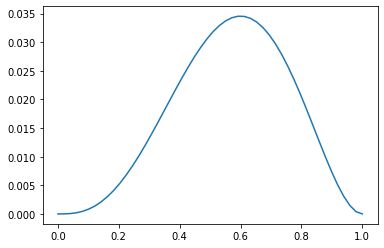

In [5]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# our dataset is {H, H, T, H, T}; if theta = P(x=H), we get:
coin_likelihood = lambda theta: theta*theta*(1-theta)*theta*(1-theta)

theta_vals = np.linspace(0,1)
plt.plot(theta_vals, coin_likelihood(theta_vals))

# Example: Flipping a Random Coin

Our log-likelihood function is
\begin{eqnarray}
\nonumber
L(\theta) &=& \theta^{\#\,\text{heads}} \cdot (1-\theta)^{\#\,\text{tails}}\\
\nonumber
\log L(\theta) &=& \log(\theta^{\#\,\text{heads}} \cdot (1-\theta)^{\#\,\text{tails}}) \\
\nonumber
&=& \#\,\text{heads} \cdot \log(\theta) + \#\,\text{tails} \cdot \log(1-\theta)
\end{eqnarray}
The MLE estimate is the $\theta^* \in [0,1]$ such that $\log L(\theta^*)$ is maximum.

Differentiating the log-likelihood function with respect to $\theta$ and setting the derivative to zero, we obtain
$$\theta^*= \frac{\#\,\text{heads}}{\#\,\text{heads}+\#\,\text{tails}}$$

When exact solutions are not available, we can optimize the log likelihood numerically, e.g. using gradient descent.

We will see examples of this later.

# Conditional Maximum Likelihood

Sometimes, we may be interested in only fitting a *conditional* model $P(y | x)$. For example, we may be only interested in predicting $y$ from $x$ rather than learning the joint structure of $x, y$.

We can extend the principle of maximum likelihood learning to this setting as well. In this case, we are interested in minimizing
$$ \min_\theta \mathbb{E}_{x \sim \mathbb{P}_\text{data}} \left[ D(P_\text{data}(y|x) \mid\mid P_\theta(y|x)) \right], $$
the expected KL divergence between $P_\text{data}(y|x)$ and $P_\theta(y|x)$ over all the inputs $x$.

With a bit of math, we can show that the maximum likelihood objective becomes
$$ \max_\theta \mathbb{E}_{x, y \sim \mathbb{P}_\text{data}} \log P_\theta(y|x). $$
This is the principle of *conditional maximum likelihood*

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 4: Extensions of Maximum Likelihood

Maximum likelihood learning is one approach for training probabilistic machine learning models.

An evern more general approach comes from Bayesian statistics. We briefly overview the Bayesian approach in this lesson.

# Review: Maximum Likelihood Learning

Recall that in maximum likelihood learning, we are optimizing the following objective:
$$ \theta_\text{MLE} = \arg\max_\theta \mathbb{E}_{x, y \sim \mathbb{P}_\text{data}} \log P(x, y; \theta). $$


# The Frequentist Approach

So far, we viewed the parameter $\theta_\text{MLE}$ as a fixed but unknown quantity that we want to determine. 
$$ \theta_\text{MLE} = \arg\max_\theta \mathbb{E}_{x, y \sim \mathbb{P}_\text{data}} \log P(x, y; \theta). $$

This view is an example of the *frequentist* approach in statistics: there exists some true value of $\theta_\text{MLE}$ and our job is to devise statistical procedure to estimate this value.

# The Bayesian Approach

In *Bayesian* statistics, $\theta$ is a *random* variable whose value happens to be unknown.

We formulate two models:
* A *likelihood* model $P(x, y | \theta)$ that defines the probability of $x,y$ for any fixed value of $\theta$.
* A *prior* $P(\theta)$ that specifies us existing belief about the distribution of the random variable $\theta$.

Together, these two models define the *joint* distribution
$$ P(x, y, \theta) = P(x, y \mid \theta) P(\theta) $$
in which both the $x, y$ and the parameters $\theta$ are random variables.

# Bayesian Inference and Learning

How do we estimate the parameter $\theta$ that is consistent with a given dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$?

Since the variable $\theta$ is a random value, in the Bayesian approach we are interested in the *posterior* probability $P(\theta \mid \mathcal{D})$ of $\theta$ given the dataset $\mathcal{D}$.

How do we obtain $P(\theta \mid \mathcal{D})$? This value is computed using Bayes' rule:
\begin{align*}
P(\theta \mid \mathcal{D})
& = \frac{P(\mathcal{D} \mid \theta) P(\theta)}{P(\mathcal{D})} \\
& = \frac{P(\mathcal{D} \mid \theta) P(\theta)}{\int_\theta P(\mathcal{D}, \theta)P(\theta) d\theta},
\end{align*}
where $P(\mathcal{D} \mid \theta) = \prod_{i=1}^n P(x^{(i)}, y^{(i)} \mid \theta)$.

# Bayesian Predictions

Suppose we now want to predict the value of $y$ from $x$. Unlike in the frequentist setting, we no longer have a single estimate $\theta$ of the model params, but instead we have a distribution.

The Bayesian approach to predicting $y$ given an input $x$ and a training dataset $\mathcal{D}$ consists of taking the prediction of all the possible models
$$ P(y | x, \mathcal{D}) = \int_\theta P(y \mid x, \theta) P(\theta \mid \mathcal{D}) d\theta. $$
This is called the *posterior predictive* distribution. Note how each $P(y \mid x, \theta)$ is weighted by the probability of $\theta$ given $\mathcal{D}$.

# The Pros and Cons of the Bayesian Approach

The Bayesian approach is very powerful. Some of its advantages include:
* Principled estimates of uncertainty, both in the prediction and in the paramters of the model.
* Ability to incorporate prior knowledge via the prior.
* Providing a general framework for reasoning about probabilistic models.

The main disadvantage is by far the computational complexity. Averaging over all possible model weights is typically intracatble. There exists an entire field of machine learning that studies how to approximate it.

# Maximum A Posteriori Learning

Instead of trying to use the posterior distribution of $P(\theta | \mathcal{D})$, a common approach is to approximate this distribution by its most likely value:
\begin{align*}
\theta_\text{MAP} & = \arg\max_\theta \log P(\theta | \mathcal{D}) \\
& = \arg\max_\theta \left( \log P(\mathcal{D} \mid \theta) + \log P(\theta) - \log P(\mathcal{D}) \right)\\
& = \arg\max_\theta \left( \log \prod_{i=1}^n P(x^{(i)}, y^{(i)} \mid \theta) + \log P(\theta) \right),
\end{align*}
where in the second line we used Bayes' theorem and in the third line we used the fact that $P(\mathcal{D})$ does not depend on $\theta$.

Thus, we have the following objective:
$$\arg\max_\theta \left( \log \prod_{i=1}^n P(x^{(i)}, y^{(i)} \mid \theta) + \log P(\theta) \right).$$
The $\theta_\text{MAP}$ is known as the *maximum a posteriori* estimate. Note that we used the same formula as we used for maximum likelihood, except that we have added the prior term $\log P(\theta)$.

# Example: Flipping a Random Coin

How should we choose $P(x\mid \theta)$ from $\cm$ if 3 out of 5 tosses are heads in $\cd$? Let's apply maximum likelihood learning.

* Our model is $P(x=H \mid \theta)=\theta$ and $P(x=T \mid \theta)=1-\theta$
* Our data is: $\cd=\{H,H,T,H,T\}$ 
* The likelihood of the data is $\prod_{i} P(x_i \mid \theta)=\theta \cdot \theta \cdot (1-\theta) \cdot \theta \cdot (1-\theta)$.

Let's now make this a MAP problem. Let's assume the prior follows the [Beta](https://en.wikipedia.org/wiki/Beta_distribution) distribution:
$$ P(\theta) = \frac{1}{B(\alpha+1, \beta+1)} \theta^\alpha (1-\theta)^\beta, $$
where $\alpha, \beta >0$ are parameters and $B$ is the Beta function.

The joint probability on $\cd=\{H,H,T,H,T\}$ is then
$$ \prod_{i} P(x_i \mid \theta) P(\theta) =\theta \cdot \theta \cdot (1-\theta) \cdot \theta \cdot (1-\theta) \frac{\theta^\alpha (1-\theta)^\beta}{B(\alpha+1, \beta+1)} $$

Let's derive an analytic solution. Our objective function is
\begin{eqnarray}
\nonumber
L(\theta) &\propto& \theta^{\#\,\text{heads}} \cdot (1-\theta)^{\#\,\text{tails}} \cdot \theta^{\alpha} \cdot (1-\theta)^\beta\\
\nonumber
\log L(\theta) &=& \log(\theta^{\#\,\text{heads}} \cdot (1-\theta)^{\#\,\text{tails}} \cdot \theta^{\alpha} \cdot (1-\theta)^\beta) + \text{const.} \\
\nonumber
&=& (\#\,\text{heads} + \alpha) \cdot \log(\theta) + (\#\,\text{tails} + \beta) \cdot \log(1-\theta)
\end{eqnarray}

Differentiating the log-likelihood function with respect to $\theta$ and setting the derivative to zero, we obtain
$$\theta^*= \frac{\#\,\text{heads} + \alpha}{\#\,\text{heads}+\#\,\text{tails} + \alpha + \beta}$$


Thus, we see that adding a Beta prior with parameters $\alpha, \beta$ allows to encode having seen $\alpha$ "virtual heads" and $\beta$ "virtual tails".

This is an example of how we can add prior knowledge into the model.

For example, if out initial dataset is
$$\cd=\{H,H,T,H,T\}$$
and we set $\alpha =1$, $\beta=1$, then the optimal $\theta^*$ will be as if we had the following dataset
$$\cd_\text{virtual}=\{H,H,T,H,T,H,T\}$$
with an extra head and tail.

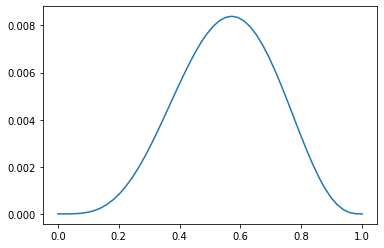

In [59]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# our dataset is {H, H, T, H, T}; if theta = P(x=H), we get:
alpha, beta = 1, 1
# our effective dataset is {H, H, T, H, T, H, T}
coin_likelihood = lambda theta: theta*theta*(1-theta)*theta*(1-theta)*(theta**alpha)*((1-theta)**beta)

theta_vals = np.linspace(0,1)
plt.plot(theta_vals, coin_likelihood(theta_vals))